In [9]:
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# (reasoning trace, did the model get the correct answer?)
completions = [
    (
        """
        I need to identify the sign on the right side of the road. The sign is visible on the side of the road as the person is walking.
 
Now, I analyze the sign. It looks like a normal traffic sign with an arrow pointing to the side. Usually, signs like these indicate directions, especially ones that show left turns to another road.

The sign on the right is the closest logical match to the options provided. This sign specifically guides drivers to make a left turn. Therefore, the correct interpretation of the sign on the right would be 'left.'

Given this analysis, the sign on the right indicates "left."
        """,
        False,
    ),
    (
        """
         The user is asking about a sign on the right side of the road in the image. The possible answers are "signal," "slow," or "stop." I'm looking for a sign that is typically placed at intersections to control traffic. 
Signal is a common term used for traffic lights that control vehicle and pedestrian movements at intersections. Slow suggests the sign instructs vehicles to slow down but doesn’t imply a stop. Stop is the most definitive instruction to halt, but it's less common in the context of a single lane road like this one.
Since we're looking for the most universally recognized traffic control sign for intersections, "signal" is the correct answer.

Therefore, the sign on the right side of the road is a signal, which means vehicle traffic is controlled at an intersection.

Answer: signal
        """,
        True,
    ),
    (
        """
         The question asks which sign is on the right side of the road. First, I'll scan the left side first, which shows a speed limit sign and reoriented posts that seem like traffic signs. Then, I'll look at the right side of the road: there are reoriented signs, but none that fit the options given (signal, slow, or stop). This implies these reoriented signs could be facing backward. Let's check for a stop sign: typically placed at intersections for crossing, this would be quite effective on the right side.

Given these considerations, my logical conclusion is that the signs on the right likely also control intersections and turn. Thus, "stop" seems like the most appropriate choice as it can effectively control traffic at intersections or large T junctions. 

Therefore, I believe the potentially reoriented sign on the right side of the road is a 'stop' sign.

The best answer is: stop.
        """,
        False,
    ),
    (
        """
         The question asks for a sign on the right side of the road in relation to the given options.
   - "signal" - This can generally refer to road signs or signals.
   - "slow" - This could also be a correct answer as it sounds like an instruction sign.
   - "stop" - This is a specific option and doesn't usually apply to general traffic signs.

   Considering the task of identifying a sign from the given options on the right side of the road, "slow" or "stop" are plausible. However, given that "stop" is the specific, least ambiguous option compared to other choices like "signal" or "slow," it aligns better with the conceptual direct instruction aspect implied in traffic signs.

Therefore, I believe the most correct answer is likely the one which translates to a specific action, which is "stop."

Answer: The sign corresponding to "stop" better fits this context than the others. Therefore, I would select "stop."
        """,
        False,
    ),
]

# Ground truth rationales
rationales = [
    "The sign has the symbol that indicates that a traffic light is up ahead.",
    "The sign on the right side of the road has a traffic light on it.",
    "There is a traffic signal up ahead.",
]


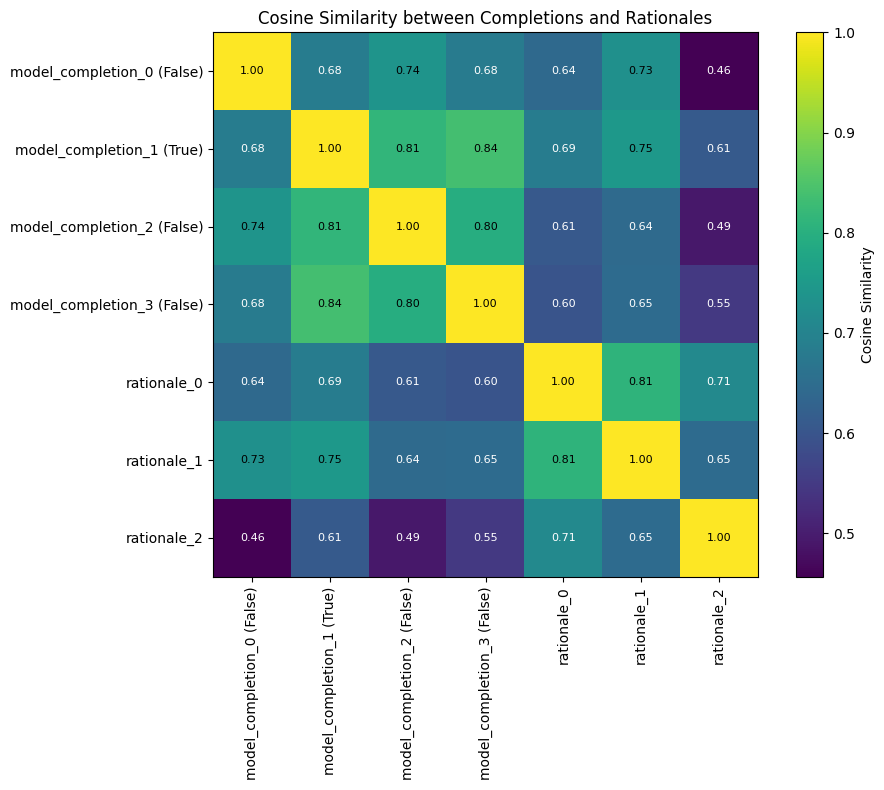

In [14]:

model_completions = [c[0] for c in completions]
model_correctness = [c[1] for c in completions]
model = SentenceTransformer("all-MiniLM-L6-v2", device="cuda:0")

# embed the model completions (4 x embedding dim)
model_completions_embeddings = model.encode(model_completions)

# embed the ground truth rationales (3 x embedding dim)
rationales_embeddings = model.encode(rationales)

# concatenate the embeddings  (7 x embedding dim)
all_embeddings = np.concatenate([model_completions_embeddings, rationales_embeddings], axis=0)

cosine_similarities = np.dot(all_embeddings, all_embeddings.T) / (
    np.linalg.norm(all_embeddings, axis=1) * np.linalg.norm(all_embeddings, axis=1).T
)


# Generate labels including correctness for model completions
num_completions = len(model_completions)
num_rationales = len(rationales)
labels = [
    f"model_completion_{i} ({model_correctness[i]})"
    for i in range(num_completions)
] + [f"rationale_{i}" for i in range(num_rationales)]

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust figure size for text readability
im = plt.imshow(cosine_similarities, cmap="viridis")
plt.colorbar(label="Cosine Similarity")
plt.title("Cosine Similarity between Completions and Rationales")

# Set ticks and labels
tick_positions = np.arange(len(labels))
plt.xticks(tick_positions, labels, rotation=90)
plt.yticks(tick_positions, labels)

# Add the score text to each cell
threshold = (
    cosine_similarities.max() + cosine_similarities.min()
) / 2.0  # Threshold for text color
for i in range(len(labels)):
    for j in range(len(labels)):
        score = cosine_similarities[i, j]
        text_color = (
            "black" if score > threshold else "white"
        )  # Adjust text color for contrast
        plt.text(
            j,
            i,
            f"{score:.2f}",
            ha="center",
            va="center",
            color=text_color,
            fontsize=8,
        )  # Add formatted text


plt.tight_layout()  # Adjust layout to prevent labels overlapping
plt.show()

# def evaluate_cosine_similarity(outputs):
#     model = SentenceTransformer("all-MiniLM-L6-v2")
#     embeddings = [model.encode(output) for output in outputs]

#     cosine_similarities = np.dot(embeddings, embeddings.T) / (
#         np.linalg.norm(embeddings, axis=1) * np.linalg.norm(embeddings, axis=1).T
#     )
#     return np.mean(cosine_similarities)


# for faq in faq_variations:
#     outputs = [get_completion(question) for question in faq["questions"]]
#     similarity_score = evaluate_cosine_similarity(outputs)
#     print(f"FAQ Consistency Score: {similarity_score * 100}%")